# Fractals, Chaos, L-Systems

In [15]:
# Settings and imports.
%matplotlib inline
import ast
from collections import Counter, OrderedDict, defaultdict
from functools import partial
from itertools import count, combinations
from math import sqrt, pi, sin, cos, atan, radians, degrees
from random import random, choice
from time import time
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

from drawing import VectorImage, Turtle, show_image

-----

# A) Chaos Game

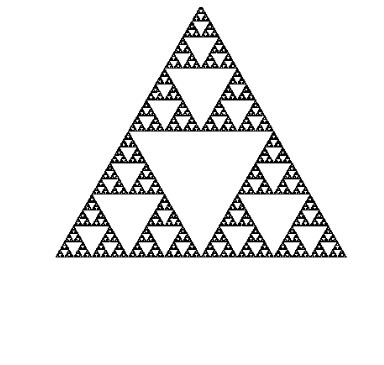

In [43]:
BLACK = (0, 0, 0)

def chaos_game(n_vertices=3, r=0.5, uniform=True, vertex_shift=False,
               drop_first=100, n_iter=int(1e5), size=400):
    im = Image.new('RGB', (size, size), color='white')
    angles = [
        radians(90 + i * 360/n_vertices)
        for i in range(n_vertices)]
    eps = 0.2 if vertex_shift else 0
    vertices = [
        (randomize(size/2 + cos(angle)*size/2, maxv=size, eps=eps),
         randomize(size/2 + sin(angle)*size/2, maxv=size, eps=eps))
        for angle in angles]
    x, y = random() * size, random() * size
    weights = [
        (1 if uniform else 2*i+1)
        for i in range(n_vertices)]
    total = sum(weights)
    weights = [w/total for w in weights]
    for i in range(n_iter):
        vertex = vertices[np.random.choice(n_vertices, p=weights)]
        x = x * r + vertex[0] * (1-r)
        y = y * r + vertex[1] * (1-r)
        if i > drop_first:
            im.putpixel((int(x), int(y)), BLACK)
    return im

def randomize(value, minv=0, maxv=100, eps=0.1):
    max_shift = (maxv - minv) * eps
    new_value = value + (random()*2 - 1) * max_shift
    new_value_capped = max(min(new_value, maxv), minv)         
    return new_value_capped

im = chaos_game(n_vertices=3, r=0.5)
show_image(im, flipy=True)

With different weights for vertices:

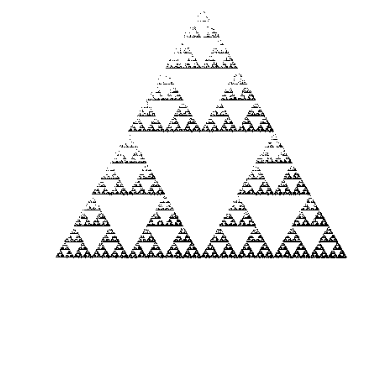

In [44]:
im = chaos_game(n_vertices=3, r=0.5, uniform=False)
show_image(im, flipy=True)

With random shift of vertices:

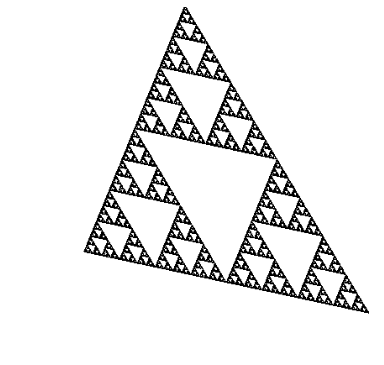

In [51]:
im = chaos_game(n_vertices=3, r=0.5, vertex_shift=True)
show_image(im, flipy=True)

With different number of vertices and ratio:

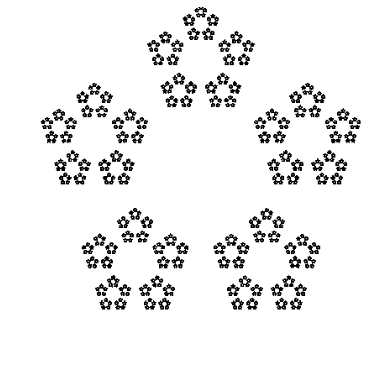

In [30]:
im = chaos_game(n_vertices=5, r=1/3)
show_image(im, flipy=True)

Several modifications combined:

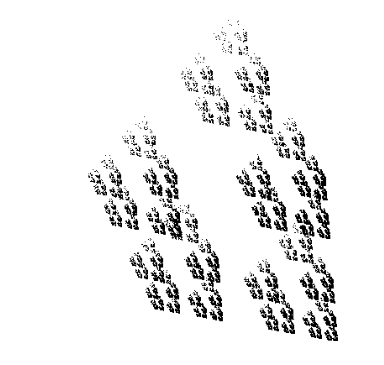

In [54]:
im = chaos_game(n_vertices=5, r=3/8, uniform=False, vertex_shift=True)
show_image(im, flipy=True)

-----

# B) Feigenbaum Diagram

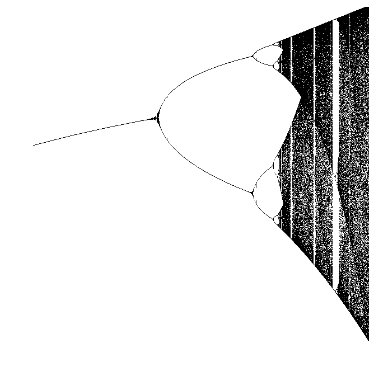

In [67]:
def feigenbaum(r_min=0.6, r_max=1.0, x_min=0, x_max=1,
               size=600, drop_first=100, n_iter=1000):
    im = Image.new('RGB', (size, size), color='white')
    r_step = (r_max - r_min) / (size-1)
    rs = [r_min + r_step*i for i in range(size)]
    x_step = (x_max - x_min) / (size-1)
    xs = [x_min + x_step*i for i in range(size)]
    for ix, r in enumerate(rs):
        x = x_min + random() * (x_max - x_min)
        for i_iter in range(n_iter):
            x = 4 * r * x * (1 - x)
            if i_iter > drop_first and x_min <= x <= x_max:
                iy = int(size * (x - x_min) / (x_max - x_min))
                im.putpixel((ix, iy), BLACK)
    return im

im = feigenbaum()
show_image(im, flipy=True)
#im.save('feigenbaum.png')

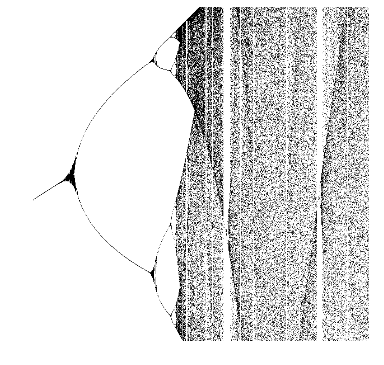

In [70]:
im = feigenbaum(r_min=0.85, r_max=0.95, x_min=0.8, x_max=0.9)
show_image(im, flipy=True)

-----

# C) L-Systems

TODO:
- allow to set linewidth base on stack depth
- stochastic version
- more fractals, experiments with own rules
- inspiration in the referenced book
- refactoring + easier description of interpretation?
  (then factor out LSystem to drawing.py)


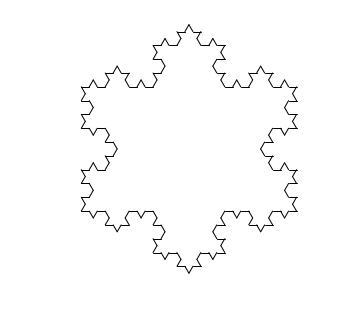

In [141]:
class LSystem:
    def __init__(self, axiom, rules, interpretation):
        self.axiom = axiom
        self.rules = remove_spaces(rules)
        self.interpretation = interpretation
        self.turtle = None
        self.stack = None
    
    def generate_description(self, n):
        description = self.axiom
        for i in range(n):
            description = ''.join([self.expand(c) for c in description])
        return description
    
    def expand(self, char):
        rules = [rule for rule in self.rules if rule[0] == char]
        if not rules:
            return char
        # Currently assumes unique rules.
        rule = rules[0]
        return rule[1]
    
    def interpret(self, char):
        assert self.turtle is not None
        if char == '[':  # push
            self.stack.append(self.turtle.state)
        elif char == ']':  # pop
            self.turtle.state = self.stack.pop()
        elif char in self.interpretation:
            action = self.interpretation[char]
            self.perform_action(action)
            #eval('self.turtle.' + action)
            
    def perform_action(self, action):
        # TODO: Refactor
        action_parts = action.split('(', 1)
        action_name = action_parts[0]
        arg = ast.literal_eval(action_parts[1][:-1])
        if action_name == 'forward':
            depth = len(self.stack)
            color = self.colors[depth]
            linewidth = self.linewidths[depth]
            self.turtle.forward(arg, color=color, linewidth=linewidth)
        elif action_name == 'left':
            self.turtle.left(arg)
        elif action_name == 'right':
            self.turtle.right(arg)            
        
    def draw(self, n=3, angle=0,
             start_color=(0, 0, 0), end_color=(0, 0, 0),
             start_linewidth=1, end_linewidth=1):
        description = self.generate_description(n)
        self.stack = []
        self.turtle = Turtle(angle=angle)
        max_depth = find_depth(description)
        if max_depth > 0:
            self.colors = [
                interpolate_color(start_color, end_color, d/max_depth)
                for d in reversed(range(max_depth+1))]
            self.linewidths = interpolate_exponentially(
                start_linewidth, end_linewidth, k=max_depth+1)
        else:
            self.colors = [start_color]
            self.linewidths = [start_linewidth]
        for char in description:
            self.interpret(char)
        self.turtle.show()

def remove_spaces(rules):
    spacefree_rules = [
        (left, right.replace(' ', ''))
        for (left, right) in rules]
    return spacefree_rules

def interpolate_color(first, second, ratio):
    return tuple(ratio*f + (1-ratio)*s for f, s in zip(first, second))

def interpolate_exponentially(start, end, k):
    b, a = np.polyfit([0, k-1], np.log([start, end]), 1)
    xs = np.arange(k)
    ys = start * np.exp(b * xs)
    return ys

def find_depth(description):
    depth = 0
    max_depth = 0
    for c in description:
        if c == '[':
            depth += 1
        if c == ']':
            depth -= 1
        max_depth = max(depth, max_depth)
    return max_depth

interpretation = {
    'F': 'forward(10)',
    '-': 'left(60)',
    '+': 'right(60)'}
koch = LSystem('F--F--F', [('F', 'F+F--F+F')], interpretation)
koch.draw(n=3)

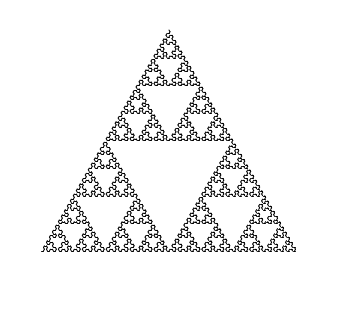

In [24]:
sierpinski = LSystem(
    'A',
    [('A', 'B-A-B'), ('B', 'A+B+A')],
    {'A': 'forward(10)',
     'B': 'forward(10)',
     '-': 'left(60)',
     '+': 'right(60)'})
sierpinski.draw(n=7)

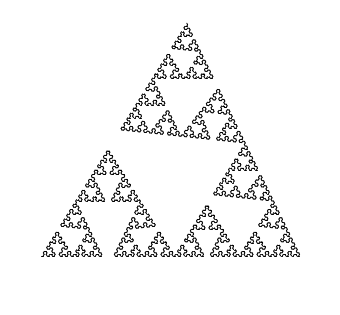

In [96]:
loose_sierpinski = LSystem(
    'A',
    [('A', 'B-A-B'), ('B', 'A+B+A')],
    {'A': 'forward(10)',
     'B': 'forward(10)',
     '-': 'left(58)',
     '+': 'right(58)'})
loose_sierpinski.draw(n=7)

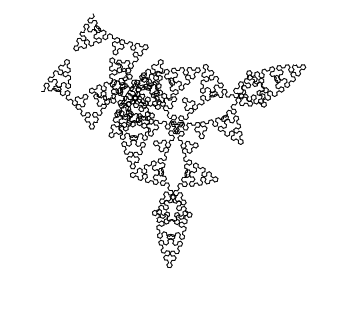

In [94]:
broken_sierpinski = LSystem(
    'A',
    [('A', 'B-A-B'), ('B', 'A+B+A')],
    {'A': 'forward(10)',
     'B': 'forward(10)',
     '-': 'left(62)',
     '+': 'right(63)'})
broken_sierpinski.draw(n=7)

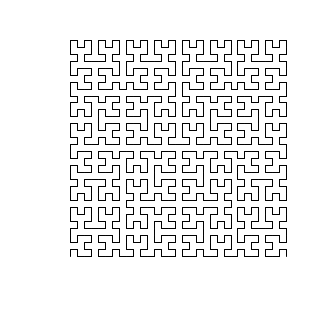

In [76]:
hilbert = LSystem(
    'A',
    [('A', '-BF+AFA+FB-'),
     ('B', '+AF-BFB-FA+')],
    {'F': 'forward(10)',
     '-': 'left(90)',
     '+': 'right(90)'})
hilbert.draw(n=5)

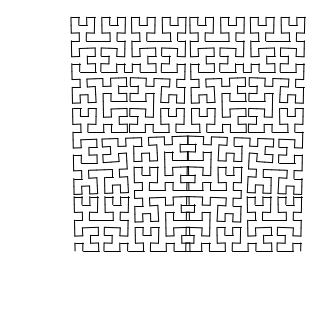

In [82]:
loose_hilbert = LSystem(
    'A',
    [('A', '-BF+AFA+FB-'),
     ('B', '+AF-BFB-FA+')],
    {'F': 'forward(10)',
     '-': 'left(91)',
     '+': 'right(91)'})
loose_hilbert.draw(n=5)

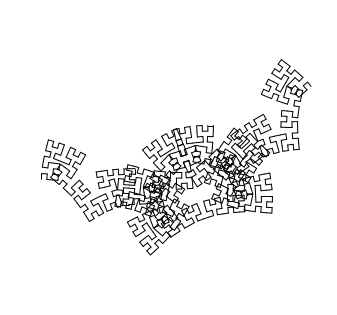

In [75]:
broken_hilbert = LSystem(
    'A',
    [('A', '-BF+AFA+FB-'),
     ('B', '+AF-BFB-FA+')],
    {'F': 'forward(10)',
     '-': 'left(90)',
     '+': 'right(91)'})
broken_hilbert.draw(n=5)

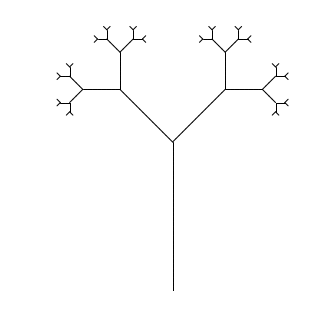

In [77]:
tree = LSystem(
    'A',
    [('A', 'F[+A]-A'), ('F', 'FF')],
    {'F': 'forward(10)',
     '-': 'left(45)',
     '+': 'right(45)'})
tree.draw(n=6, angle=90)

Adding colors:

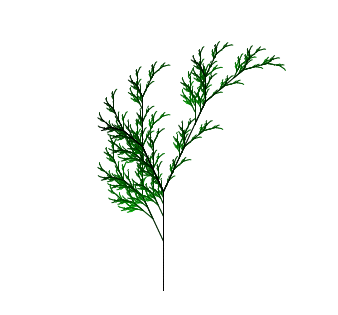

In [57]:
tree = LSystem(
    'A',
    [('A', 'F - [ [ A ] + A ] + F [ + F A ] - A'),
     ('F', 'F F')],
    {'F': 'forward(10)',
     '-': 'left(25)',
     '+': 'right(25)'})
tree.draw(n=6, angle=90, end_color=(0, 0.8, 0))

Adding linewidth:

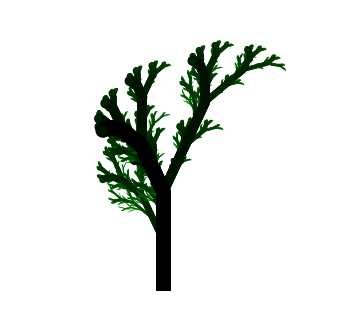

In [149]:
tree = LSystem(
    'A',
    [('A', 'F - [ [ A ] + A ] + F [ + F A ] - A'),
     ('F', 'F F')],
    {'F': 'forward(10)',
     '-': 'left(25)',
     '+': 'right(25)'})
tree.draw(n=6, angle=90, end_color=(0, 0.8, 0),
          start_linewidth=15, end_linewidth=0.1)

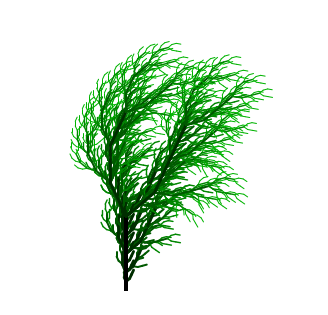

In [148]:
bush = LSystem(
    'F',
    [('F', 'FF+[+F-FF]-[-F+F+F]')],
    {'F': 'forward(10)',
     '-': 'left(25)',
     '+': 'right(25)'})
bush.draw(n=4, angle=90, end_color=(0, 0.7, 0), start_linewidth=4)